https://krasserm.github.io/2019/11/21/latent-variable-models-part-1/

# 1. Introduction

**A latent variable model makes the assumption that an observation xi is caused by some underlying latent variable, a variable that cannot be observed directly** but can be inferred from observed variables and parameters. For example, the following plot shows observations in 2-dimensional space and one can see that their overall distribution doesn't seem follow a simple distribution like a single Gaussian

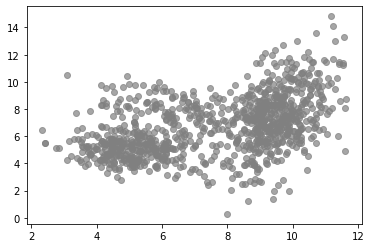

In [2]:
from latent_variable_models_util import n_true, mu_true, sigma_true
from latent_variable_models_util import generate_data, plot_data, plot_densities
from scipy.stats import multivariate_normal as mvn
import numpy as np

%matplotlib inline

X, T = generate_data(n=n_true, mu=mu_true,sigma=sigma_true)

plot_data(X, color='grey')

But we can see that there are clusters of higher density. Also, the distribution within a cluster looks more like a Gaussian compared to the overall distribution. Indeed, these data were generated using a mixture of three Gaussians

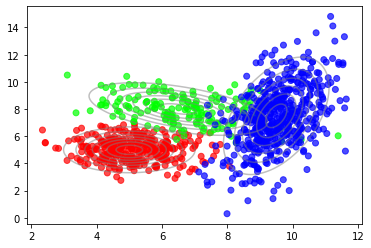

In [3]:
plot_data(X, color=T)
plot_densities(X, mu=mu_true, sigma=sigma_true)

# 2. Model

### 2.1. Observed data and the marginal distribution p(x|θ)

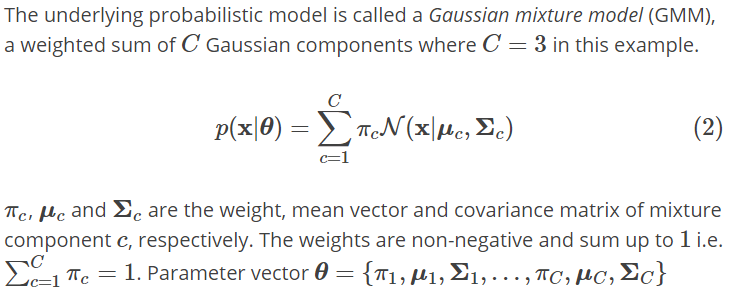

<br>

### 2.2. Introduce latent vars and the joint distribution over observed and latent vars

If we introduce a discrete latent variable t that determines the assignment of observations to mixture components we can define a joint distribution over observed and latent variables p(x,t|θ) in terms of a conditional distribution p(x|t,θ)  and a prior distribution p(t|θ)

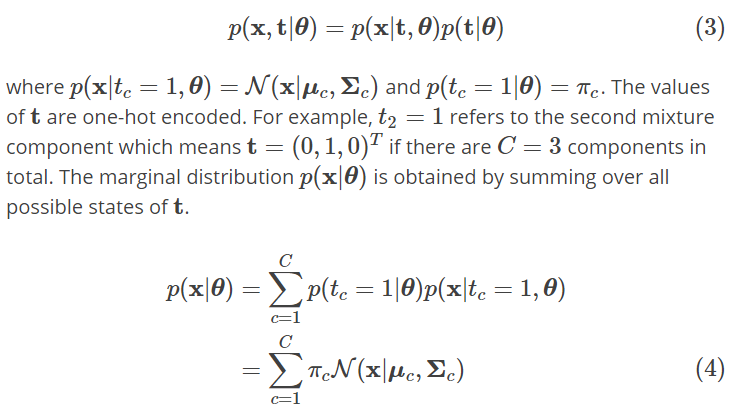

### 2.3. Incomplete-data likelihood vs. complete data likelihood

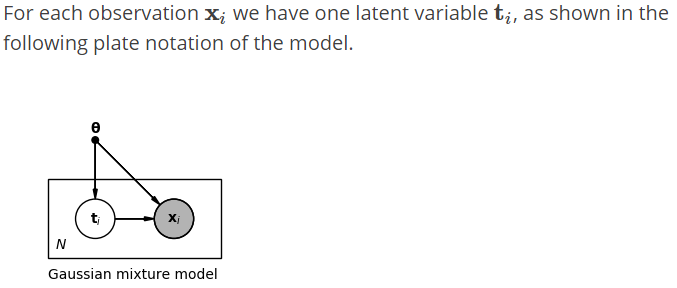

We denote the set of all observations by X and the set of all latent variables by T. If we could observe T directly, we could easily maximize the complete-data likelihood p(X,T|θ) because we would then know the assignment of data points to components, and fitting a single Gaussian per component can be done analytically. But since we can only observe X, we have to maximize the marginal likelihood or incompleted-data likelihoo p(X|θ). 

### 2.4. Likelihood function and lower bound funtion of likelihood

By using the logarithm of the likelihood we have

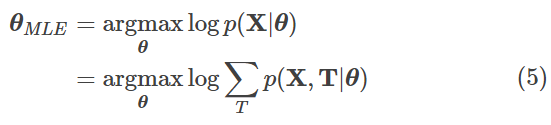

which involves a summation over latent variables inside the logarithm. This prevents a simple analytical solution to the optimzation problem

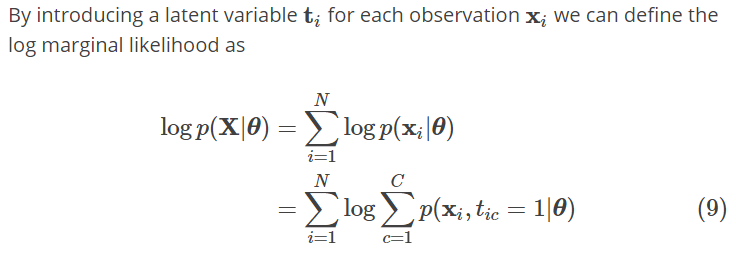

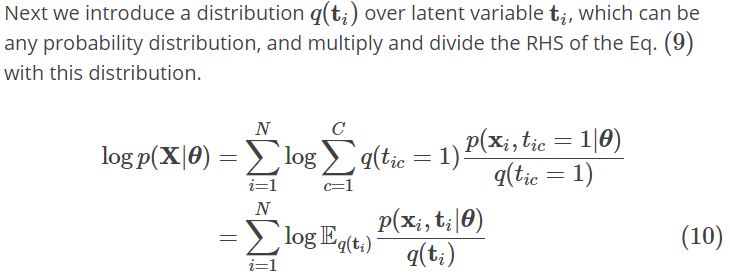

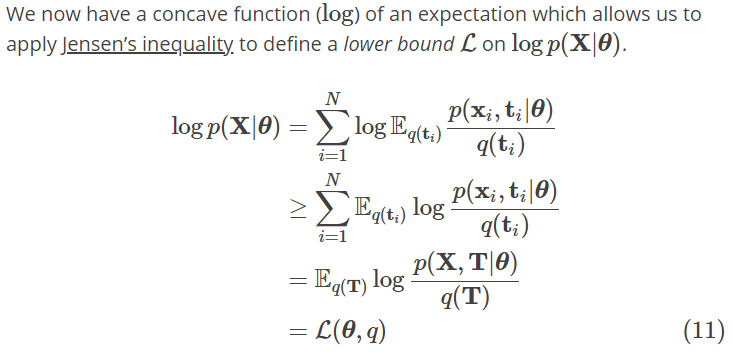

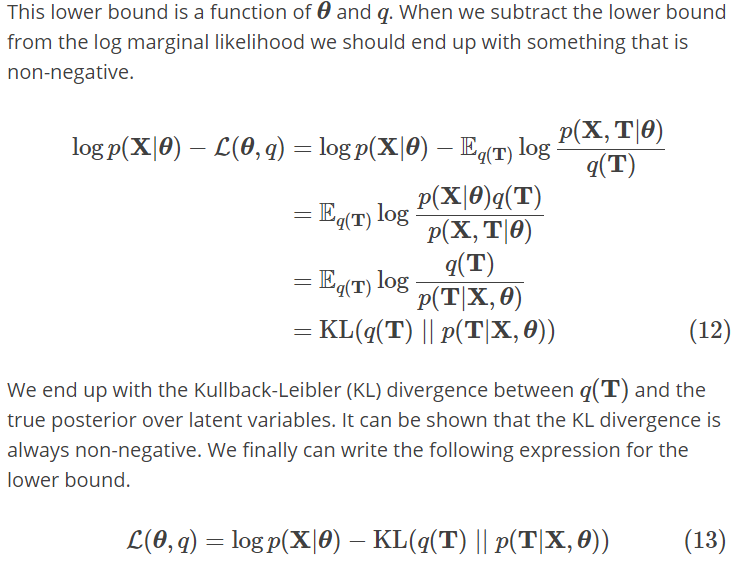

# 3. Expectation maximization algorithm

### 3.1. E-step

In the E-step of the EM algorithm L(θ,q) is maximized w.r.t q and θ if held fixed.

\begin{align*}
q^{new} &= 
\underset{q}{\mathrm{argmax}} \mathcal{L}(\boldsymbol{\theta}^{old}, q) \\ &=
\underset{q}{\mathrm{argmin}} \mathrm{KL}(q(\mathbf{T}) \mid\mid p(\mathbf{T} \lvert \mathbf{X}, \boldsymbol{\theta}^{old}))
\tag{14}
\end{align*}

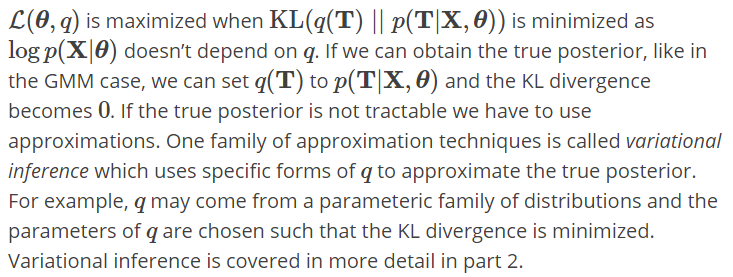


In [4]:
def e_step(X, pi, mu, sigma):
    """
    Computes porsterior probabilities from data and parameters
    
    Args:
        X: Observed data (N, D)
        pi: prior probabilities (C,)
        mu: mixture component means (C, D)
        sigma: mixture component covariates (C, D, D)
        
    Returns:
        Posterior probabilities (N, C)
    """
    
    N = X.shape[0]
    C = mu.shape[0]
    q = np.zeros((N, C))
    
    # Equation (6)
    for c in range(C):
        q[:, c] = mvn(mu[c], sigma[c]).pdf(X) * pi[c]  
        
    return q / np.sum(q, axis=-1, keepdims=True) 

### 3.2. M-step

In the M-step L(θ,q) is maximized w.r.t. θ and q is held fixed. Using Eq. (11) we get

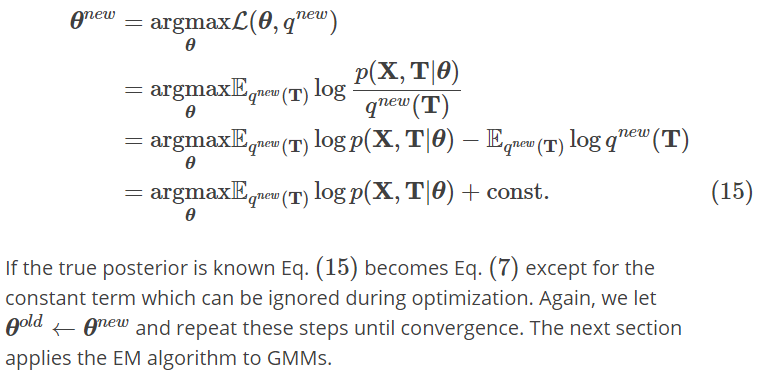



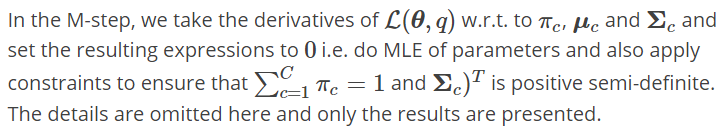

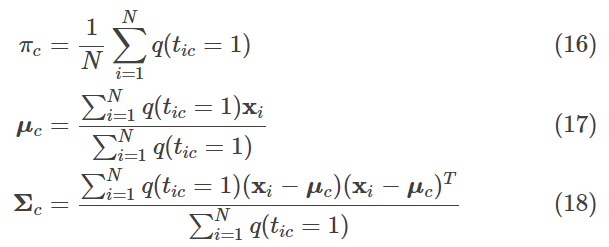

In [5]:
def m_step(X, q):
    """
    Computes parameters from data and posterior probabilities.

    Args:
        X: data (N, D).
        q: posterior probabilities (N, C).

    Returns:
        tuple of
        - prior probabilities (C,).
        - mixture component means (C, D).
        - mixture component covariances (C, D, D).
    """    
    
    N, D = X.shape
    C = q.shape[1]    
    sigma = np.zeros((C, D, D))
    
    # Equation (16)
    pi = np.sum(q, axis=0) / N

    # Equation (17)
    mu = q.T.dot(X) / np.sum(q.T, axis=1, keepdims=True)
    
    # Equation (18)
    for c in range(C):
        delta = (X - mu[c])
        sigma[c] = (q[:, [c]] * delta).T.dot(delta) / np.sum(q[:, c])
        
    return pi, mu, sigma  

### 3.3. Computing the lower bound

For computing the lower bound, using the results from the E-step and M-step, we first re-arrange Eq. (11)

\begin{align*}
\mathcal{L}(\boldsymbol{\theta}, q) &= 
\sum_{i=1}^{N} \mathbb{E}_{q(\mathbf{t}_i)} \log {p(\mathbf{x}_i, \mathbf{t}_i \lvert \boldsymbol{\theta}) \over q(\mathbf{t}_i)} \\ &=
\sum_{i=1}^{N} \sum_{c=1}^{C} q(t_{ic} = 1) \log {p(\mathbf{x}_i, t_{ic} = 1 \lvert \boldsymbol{\theta}) \over q(t_{ic} = 1)} \\ &=
\sum_{i=1}^{N} \sum_{c=1}^{C} q(t_{ic} = 1) \left\{ \log p(\mathbf{x}_i \lvert t_{ic} = 1, \boldsymbol{\theta}) + \log p(t_{ic} = 1 \lvert \boldsymbol{\theta}) - \log q(t_{ic} = 1) \right\}
 \tag{19}
\end{align*}

In [6]:
def lower_bound(X, pi, mu, sigma, q):
    """
    Computes lower bound from data, parameters and posterior probabilities.

    Args:
        X: observed data (N, D).
        pi: prior probabilities (C,).
        mu: mixture component means (C, D).
        sigma: mixture component covariances (C, D, D).
        q: posterior probabilities (N, C).

    Returns:
        Lower bound.
    """    

    N, C = q.shape
    ll = np.zeros((N, C))
    
    # Equation (19)
    for c in range(C):
        ll[:,c] = mvn(mu[c], sigma[c]).logpdf(X)
    return np.sum(q * (ll + np.log(pi) - np.log(np.maximum(q, 1e-8))))

### 3.4. Training model

Model training iterates over E- and M-steps alternately until convergence of the lower bound. To increase the chance of escaping local maxima and finding the global maximum, training is restarted several times from random initial parameters.

In [10]:
def random_init_params(X, C):
    D = X.shape[1]
    pi = np.ones(C) / C
    mu = mvn(mean=np.mean(X, axis=0), cov=[np.var(X[:, 0]), 
                                           np.var(X[:, 1])]).rvs(C).reshape(C, D)
    sigma = np.tile(np.eye(2), (C, 1, 1))
    return pi, mu, sigma


def train(X, C, n_restarts=1, max_iter=5, rtol=1e-3):
    q_best = None
    pi_best = None
    mu_best = None
    sigma_best = None
    lb_best = -np.inf

    for _ in range(n_restarts):
        pi, mu, sigma = random_init_params(X, C)
        
        prev_lb = None

        try:
            for _ in range(max_iter):
                q = e_step(X, pi, mu, sigma)
                #print(q[0:5])
                pi, mu, sigma = m_step(X, q)
                print('mu: ',mu)
                print()
                print('pi: ',pi)
                print()
                print('sigma: ',sigma)
                print()
                lb = lower_bound(X, pi, mu, sigma, q)
                print('lb: ',lb)
                print() 
                if lb > lb_best:
                    q_best = q
                    pi_best = pi
                    mu_best = mu
                    sigma_best = sigma
                    lb_best = lb

                if prev_lb and np.abs((lb - prev_lb) / prev_lb) < rtol:
                    break

                prev_lb = lb
        except np.linalg.LinAlgError:
            # Singularity. One of the components collapsed
            # onto a specific data point. Start again ...
            pass

    return pi_best, mu_best, sigma_best, q_best, lb_best

pi_best, mu_best, sigma_best, q_best, lb_best = train(X, C=3)


mu:  [[9.46367265 4.29701565]
 [8.87543162 8.07815282]
 [5.26621318 5.05516844]]

pi:  [0.0700081  0.57192292 0.35806898]

sigma:  [[[ 0.56781038  0.55572164]
  [ 0.55572164  1.61935896]]

 [[ 2.37998799  0.34439145]
  [ 0.34439145  2.69732486]]

 [[ 1.36898038 -0.33308504]
  [-0.33308504  1.13086998]]]

lb:  -4216.054161056007

mu:  [[9.27965317 4.3942765 ]
 [8.81807884 7.9673564 ]
 [5.16647877 5.08743562]]

pi:  [0.07488244 0.58872296 0.3363946 ]

sigma:  [[[ 0.49035016  0.5674404 ]
  [ 0.5674404   2.11640441]]

 [[ 2.55233739  0.46568942]
  [ 0.46568942  3.01243426]]

 [[ 1.18503635 -0.2160534 ]
  [-0.2160534   1.09926765]]]

lb:  -4147.779281948033

mu:  [[9.22477253 4.61106286]
 [8.77106407 7.92388132]
 [5.09692574 5.09373091]]

pi:  [0.08451169 0.59292461 0.3225637 ]

sigma:  [[[ 0.44830742  0.56234943]
  [ 0.56234943  2.40154427]]

 [[ 2.67242014  0.55375388]
  [ 0.55375388  3.18355141]]

 [[ 1.03925568 -0.16382714]
  [-0.16382714  1.05556376]]]

lb:  -4129.363907271743

mu:  [[

In [ ]:
print(f'Lower bound = {lb_best:.2f}')
print()
print(pi_best)
print()
print(q_best)
print()
print(mu_best)
print()
print(sigma_best)

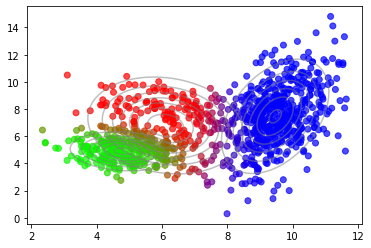

In [8]:
plot_data(X, color=q_best)
plot_densities(X, mu=mu_best, sigma=sigma_best)

### 3.5. Optimal number of components

Usually, we do not know the optimal number of mixture components a priori. But we can get a hint when plotting the lower bound vs. the number of mixture components.

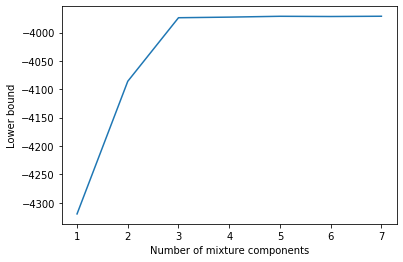

In [23]:
import matplotlib.pyplot as plt

Cs = range(1, 8)
lbs = []

for C in Cs:
    lb = train(X, C)[-1]
    lbs.append(lb)
    
plt.plot(Cs, lbs)
plt.xlabel('Number of mixture components')
plt.ylabel('Lower bound');


There is a strong increase in the lower bound value until C=3 and then the lower bound more or less doesn’t increase any more. With more components there are of course more options to overfit but the simplest model that reaches a relatively high lower bound value is a GMM with 3 components. This is exactly the number of components used to generate the data.

A more principled approach to determine the optimal number of components requires a Bayesian treatment of model parameters. In this case the lower bound would also take into account model complexity and we would see decreasing lower bound values for C>3 and a maximum at C=3. For details see section 10.2.4 in [1].

## 3.6. Implementation with scikit-learn

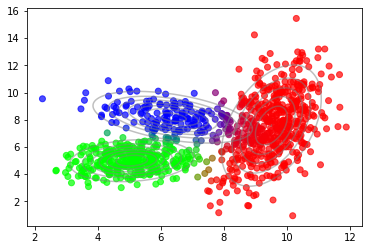

In [24]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(X)

plot_data(X, color=gmm.predict_proba(X))
plot_densities(X, mu=gmm.means_, sigma=gmm.covariances_)

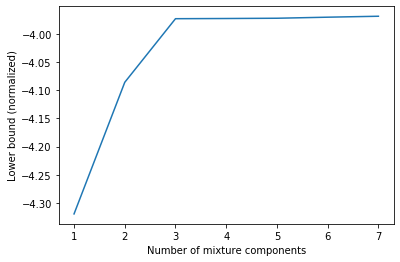

In [25]:
Cs = range(1, 8)
lbs = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    lbs.append(gmm.lower_bound_)
    
plt.plot(Cs, lbs)
plt.xlabel('Number of mixture components')
plt.ylabel('Lower bound (normalized)');

The lower bound values obtained via gmm.lower_bound_ are normalized i.e. divided by N=1000 in this example.